In [21]:
import os
import sys
from pathlib import Path
import numpy as np
import transform
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from options.train_options import TrainOptions
from models import create_model
from util.visualizer import Visualizer
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision import transforms
from PIL import Image
import mediapipe as mp
import numpy as np
import os
import csv
import sys
import gc
import torch
import random
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
torch.cuda.empty_cache()



BASE_DIR = Path(r"C:\Users\User\PycharmProjects\DeepVisionFinalProject\cycleGAN_sunglassesFilter\dataset")
CYCLEGAN_REPO_PATH = Path("C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix")
sys.path.append(str(CYCLEGAN_REPO_PATH))
print(list(CYCLEGAN_REPO_PATH.glob("*")))  # נבדוק מה יש שם באמת
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")






True
1
[WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/.gitignore'), WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/.replit'), WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/checkpoints'), WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/CycleGAN.ipynb'), WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/cycleGAN_sunglassesFilter.ipynb'), WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/data'), WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/datasets'), WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/docs'), WindowsPath('C:/Users/User/PycharmProjects/DeepVisionFinalProject/pytorch-CycleGAN-and-pix2pix/environment.yml'

In [22]:
# Step 1: Imports and path setup
# הגדרת הנתיב הראשי
PROJECT_DIR = Path(r"C:\Users\User\PycharmProjects\DeepVisionFinalProject\cycleGAN_sunglassesFilter\dataset")

# בדיקה שהנתיב קיים
assert PROJECT_DIR.exists(), f"Project directory {PROJECT_DIR} does not exist!"

# הדפסת מבנה התיקיות
for folder in ["trainA", "trainB", "testA", "testB"]:
    path = PROJECT_DIR / folder
    if path.exists():
        print(f"{folder}: {len(list(path.iterdir()))} items")
    else:
        print(f"Warning: {folder} לא נמצאה ב־{PROJECT_DIR}")


trainA: 1230 items
trainB: 1308 items
testA: 52 items
testB: 58 items


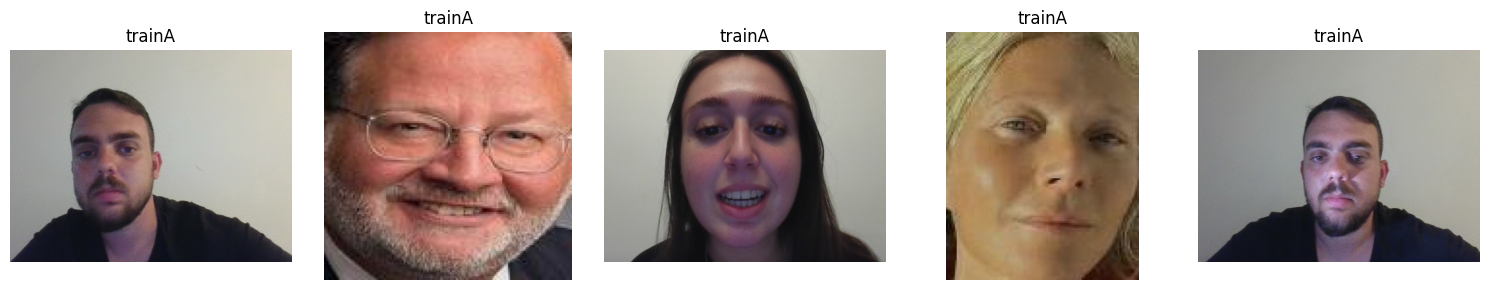

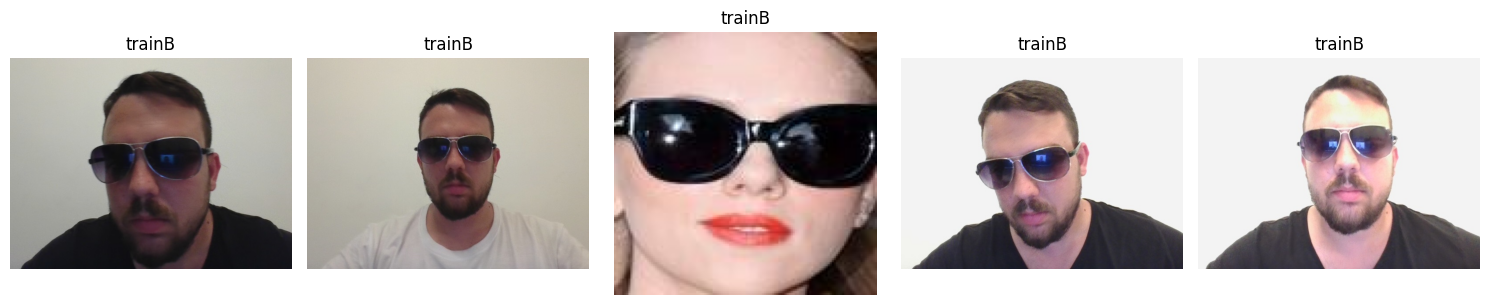

In [23]:

### Step 2: Visualize random samples from each domain
def show_random_samples(domain_folder: str, n_samples: int = 5):
    """
    מציג n תמונות אקראיות מתוך התיקייה domain_folder
    """
    folder_path = PROJECT_DIR / domain_folder
    images = list(folder_path.glob("*.*"))
    if len(images) < n_samples:
        raise ValueError(f"לא נמצאו מספיק תמונות ב־{domain_folder}")

    samples = random.sample(images, n_samples)
    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*3, 3))
    for ax, img_path in zip(axes, samples):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(domain_folder)
    plt.tight_layout()
    plt.show()

# הדגמה:
show_random_samples("trainA", n_samples=5)   # דוגמת תמונות ללא משקפיים
show_random_samples("trainB", n_samples=5)   # דוגמת תמונות עם משקפיים


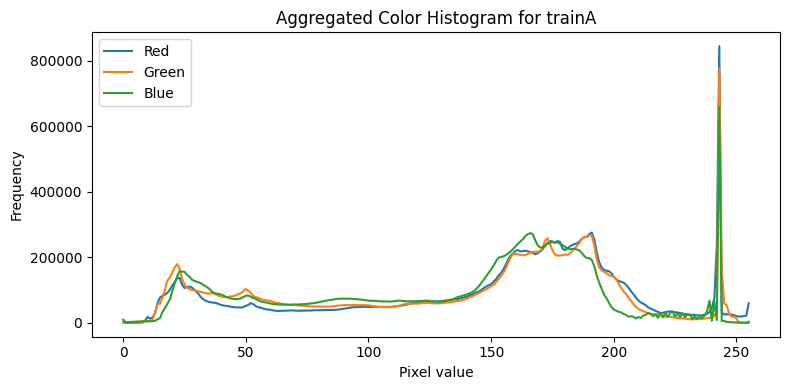

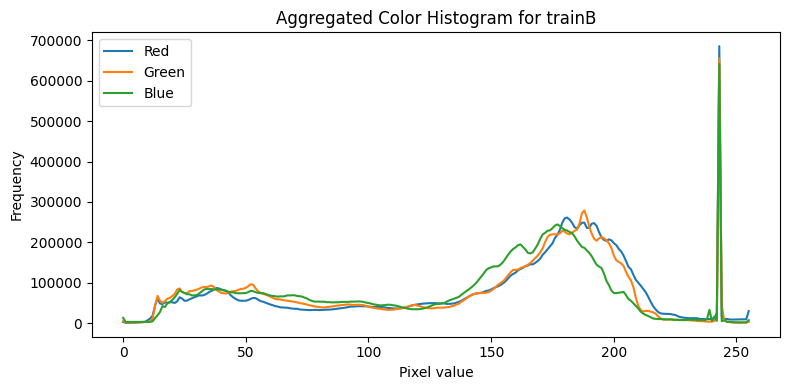

In [24]:
### Step 3: Color histogram analysis
def compute_color_histogram(image: Image.Image, bins: int = 256):
    """
    מקבל PIL Image ומחזיר מערך שלושה וקטורי היסטוגרמה (R, G, B)
    """
    arr = np.array(image)
    hist_r, _ = np.histogram(arr[:, :, 0].flatten(), bins=bins, range=(0, 255))
    hist_g, _ = np.histogram(arr[:, :, 1].flatten(), bins=bins, range=(0, 255))
    hist_b, _ = np.histogram(arr[:, :, 2].flatten(), bins=bins, range=(0, 255))
    return hist_r, hist_g, hist_b

def plot_domain_histogram(domain_folder: str, sample_size: int = 50):
    """
    לוקח sample_size תמונות אקראיות מ־domain_folder, מחשב היסטוגרמה מצטברת ומצייר
    """
    folder_path = PROJECT_DIR / domain_folder
    images = list(folder_path.glob("*.*"))
    if len(images) == 0:
        raise ValueError(f"No images found in {domain_folder}")

    # קח מדגם
    np.random.seed(42)
    sample_paths = np.random.choice(images, min(sample_size, len(images)), replace=False)

    # מצטבר
    agg_r = np.zeros(256, dtype=int)
    agg_g = np.zeros(256, dtype=int)
    agg_b = np.zeros(256, dtype=int)

    for img_path in sample_paths:
        img = Image.open(img_path).convert("RGB")
        hist_r, hist_g, hist_b = compute_color_histogram(img)
        agg_r += hist_r
        agg_g += hist_g
        agg_b += hist_b

    # ציור
    plt.figure(figsize=(8, 4))
    bins = np.arange(256)
    plt.plot(bins, agg_r, label='Red')
    plt.plot(bins, agg_g, label='Green')
    plt.plot(bins, agg_b, label='Blue')
    plt.title(f"Aggregated Color Histogram for {domain_folder}")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# קריאה לדוגמה:
plot_domain_histogram("trainA", sample_size=100)   # ללא משקפיים
plot_domain_histogram("trainB", sample_size=100)   # עם משקפיים


In [25]:

##collect_images_from_camera

def get_last_index(folder: Path, class_name: str) -> int:
    """Return *next* numeric index based on existing filenames <class>_<###>.jpg."""
    idxs = []
    for f in folder.glob(f'{class_name}_*.jpg'):
        try:
            idxs.append(int(f.stem.split('_')[-1]))
        except ValueError:
            pass
    return max(idxs) + 1 if idxs else 0

def collect_images_from_camera(
    class_name: str,
    output_dir: Path = PROJECT_DIR,
    max_images: int = 80,
    interval: int = 5,
):
    save_path = output_dir / class_name
    save_path.mkdir(parents=True, exist_ok=True)

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError('❌ Cannot open camera')

    frame_cnt, saved_cnt = 0, 0
    next_idx = get_last_index(save_path, class_name)
    print(f"▶ Collecting '{class_name}' images  … press q to stop")

    while saved_cnt < max_images:
        ret, frame = cap.read()
        if not ret:
            print('⚠️  Frame capture failed. Exiting.')
            break

        # show live feed
        cv2.imshow('Capture', frame)

        # save every Nth frame
        if frame_cnt % interval == 0:
            fname = save_path / f"{class_name}_{next_idx:03d}.jpg"
            cv2.imwrite(str(fname), frame)
            saved_cnt += 1
            next_idx += 1

        frame_cnt += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print(f'✔ Collected {saved_cnt} images → {save_path}')


#without sunglasses (face only)
#collect_images_from_camera(class_name="trainA", max_images=45, interval=10)

#with sunglasses
#collect_images_from_camera(class_name="trainB", max_images=30, interval=10)


In [26]:

class UnalignedDataset(Dataset):
    def __init__(self, dataroot, phase='train', transform=None):
        self.dir_A = dataroot / f"{phase}A"
        self.dir_B = dataroot / f"{phase}B"

        # בדיקה חכמה: רק קבצים שבאמת קיימים
        self.A_paths = sorted([p for p in self.dir_A.glob('*.*') if p.exists()])
        self.B_paths = sorted([p for p in self.dir_B.glob('*.*') if p.exists()])

        self.transform = transform

        # זיהוי פנים (MediaPipe)
        self.face_detector = mp.solutions.face_detection.FaceDetection(
            model_selection=0, min_detection_confidence=0.7
        )

        # ⚠️ אזהרה אם אין בכלל קבצים
        if not self.A_paths:
            print(f"⚠️ Warning: No images found in {self.dir_A}")
        if not self.B_paths:
            print(f"⚠️ Warning: No images found in {self.dir_B}")

    def crop_face(self, img: Image.Image) -> Image.Image:
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        results = self.face_detector.process(img_cv)

        if results.detections:
            bbox = results.detections[0].location_data.relative_bounding_box
            h, w, _ = img_cv.shape
            x = int(bbox.xmin * w)
            y = int(bbox.ymin * h)
            width = int(bbox.width * w)
            height = int(bbox.height * h)

            x = max(x, 0)
            y = max(y - int(0.4 * height), 0)
            height = min(height + int(0.4 * height), h - y)
            width = min(width, w - x)

            return img.crop((x, y, x + width, y + height))

        return img  # אם אין פנים – מחזיר את המקור

    def __getitem__(self, index):
        A_path = self.A_paths[index % len(self.A_paths)]
        B_path = self.B_paths[index % len(self.B_paths)]

        A_img = Image.open(A_path).convert('RGB')
        B_img = Image.open(B_path).convert('RGB')

        # Crop face
        A_img = self.crop_face(A_img)
        B_img = self.crop_face(B_img)

        if self.transform:
            A = self.transform(A_img)
            B = self.transform(B_img)

        return {'A': A, 'B': B, 'A_paths': str(A_path), 'B_paths': str(B_path)}

    def __len__(self):
        return max(len(self.A_paths), len(self.B_paths))


In [27]:
train_dataset = UnalignedDataset(BASE_DIR, phase='train', transform=transform)
print(f"Found {len(train_dataset.A_paths)} images in trainA")
print(f"Found {len(train_dataset.B_paths)} images in trainB")


Found 1230 images in trainA
Found 1308 images in trainB


In [28]:
transform = transforms.Compose([
transforms.Resize((256, 256)),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_dataset = UnalignedDataset(BASE_DIR, phase='train', transform=transform)
print(f"Found {len(train_dataset.A_paths)} images in trainA")
print(f"Found {len(train_dataset.B_paths)} images in trainB")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)


Found 1230 images in trainA
Found 1308 images in trainB


In [32]:
### ניקוי זיכרון קודם (מאוד חשוב בהרצות חוזרות)
gc.collect()
torch.cuda.empty_cache()

# בדיקה כמה GPUs זמינים והגדרה בהתאם
if torch.cuda.is_available():
    available_gpu_count = torch.cuda.device_count()
    gpu_id_to_use = 0  # תמיד GPU הראשון שלך
    print(f"Detected {available_gpu_count} GPU(s). Using GPU ID {gpu_id_to_use}")
else:
    gpu_id_to_use = -1  # CPU Mode
    print("CUDA not available. Using CPU.")

# ✅ יצירת argv בצורה בטוחה ומוגנת
sys.argv = [
    'train.py',
    '--dataroot', str(BASE_DIR),
    '--name', 'cycleGAN_sunglassesFilter_LAST_TRAIN_200',
    '--model', 'cycle_gan',
    '--batch_size', '4',
    '--n_epochs', '100',
    '--n_epochs_decay', '100',
    '--gpu_ids', str(gpu_id_to_use),
    '--display_id', '-1',
    '--epoch_count', '1'

]

# ✅ parse כולל gpu_ids נכון
opt = TrainOptions().parse()

# ✅ יצירת המודל באופן בטוח (פעם אחת בלבד!)
model = create_model(opt)
model.setup(opt)

# ✅ יצירת Visualizer פעם אחת (רק אחרי setup)
visualizer = Visualizer(opt)


Detected 1 GPU(s). Using GPU ID 0
----------------- Options ---------------
               batch_size: 4                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: C:\Users\User\PycharmProjects\DeepVisionFinalProject\cycleGAN_sunglassesFilter\dataset	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          disp

In [19]:
# ### RUN TRAIN LOOP
#
# # === יצירת תיקיות במידת הצורך ===
# os.makedirs('checkpoints/epoch_outputs', exist_ok=True)
# os.makedirs('checkpoints/web', exist_ok=True)
#
# # === יצירת index.html אם לא קיים ===
# index_html_path = 'checkpoints/web/index.html'
# if not os.path.exists(index_html_path):
#     with open(index_html_path, 'w') as f:
#         f.write('''<!DOCTYPE html>
# <html lang="en">
# <head>
#     <meta charset="UTF-8">
#     <title>CycleGAN Output</title>
#     <meta http-equiv="refresh" content="10">
#     <style>
#         body { text-align: center; font-family: sans-serif; background-color: #f0f0f0; }
#         img { border: 5px solid #333; border-radius: 15px; }
#     </style>
# </head>
# <body>
#     <h1>CycleGAN - Sunglasses Filter</h1>
#     <p>Image updates after each epoch</p>
#     <img src="output_epoch.jpg" width="512" height="512" alt="Generated Image">
# </body>
# </html>''')
#     print(f"Created checkpoints/web/index.html")
#
# # === יצירת קובץ CSV ללוג אם לא קיים ===
# csv_file = 'checkpoints/training_log.csv'
# if not os.path.exists(csv_file):
#     with open(csv_file, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['epoch', 'D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B'])
#     print(f"Created {csv_file} for logging losses")
#
# # === לולאת אימון ===
# total_epochs = opt.n_epochs + opt.n_epochs_decay
#
# for epoch in range(opt.epoch_count, total_epochs + 1):
#     print(f"Starting epoch {epoch}/{total_epochs}...")
#
#     for i, data in enumerate(train_loader):
#         model.set_input(data)
#         model.optimize_parameters()
#
#         if i % opt.print_freq == 0:
#             losses = model.get_current_losses()
#             print(f"Epoch {epoch}, Iter {i}: {losses}")
#
#     # עדכון learning rate
#     model.update_learning_rate()
#
#     # === שמירת מודלים ===
#     if epoch % opt.save_epoch_freq == 0:
#         print(f"Saving model at epoch {epoch}")
#         model.save_networks(epoch)
#
#     # === שמירת תמונת output ===
#     with torch.no_grad():
#         sample_data = next(iter(train_loader))
#         model.set_input(sample_data)
#         model.forward()
#
#         fake_B = model.fake_B[0].cpu()
#         fake_B = (fake_B + 1) / 2.0  # Normalization from [-1,1] to [0,1]
#         fake_B_img = fake_B.permute(1, 2, 0).numpy() * 255
#         fake_B_img = fake_B_img.astype('uint8')
#
#         # שמירת היסטוריה checkpoints/epoch_outputs
#         output_epoch_path = f'checkpoints/epoch_outputs/output_epoch_{epoch:03d}.jpg'
#         Image.fromarray(fake_B_img).save(output_epoch_path)
#         print(f"Saved output image for epoch {epoch} to {output_epoch_path}")
#
#         # עדכון live output לתיקיית web
#         web_output_path = 'checkpoints/web/output_epoch.jpg'
#         Image.fromarray(fake_B_img).save(web_output_path)
#         print(f"Updated checkpoints/web/output_epoch.jpg for epoch {epoch}")
#
#     # === Logging תוצאות epoch ל-CSV ===
#     losses = model.get_current_losses()
#     with open(csv_file, 'a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow([
#             epoch,
#             losses['D_A'],
#             losses['G_A'],
#             losses['cycle_A'],
#             losses['idt_A'],
#             losses['D_B'],
#             losses['G_B'],
#             losses['cycle_B'],
#             losses['idt_B']
#         ])
#     print(f"Logged epoch {epoch} losses to {csv_file}")


Starting epoch 1/200...
Epoch 1, Iter 0: OrderedDict([('D_A', 0.06709851324558258), ('G_A', 0.8327813744544983), ('cycle_A', 0.6623475551605225), ('idt_A', 0.15193915367126465), ('D_B', 0.0998489111661911), ('G_B', 0.647514283657074), ('cycle_B', 0.6029472947120667), ('idt_B', 0.32723039388656616)])


KeyboardInterrupt: 

In [68]:
# epoch_to_save = " "  # לדוגמה, האפוק האחרון
# model.save_networks(epoch_to_save)
# print(f"Model saved successfully at epoch {epoch_to_save}")


Model saved successfully at epoch latest


In [33]:
### LOAD MODEL
epoch_to_load = 110  # מה שתרצה לבדוק
model.load_networks(epoch_to_load)
model.eval()
print(f"Model loaded successfully from epoch {epoch_to_load}")


loading the model from ./checkpoints\cycleGAN_sunglassesFilter_LAST_TRAIN_200\110_net_G_A.pth
loading the model from ./checkpoints\cycleGAN_sunglassesFilter_LAST_TRAIN_200\110_net_G_B.pth
loading the model from ./checkpoints\cycleGAN_sunglassesFilter_LAST_TRAIN_200\110_net_D_A.pth
loading the model from ./checkpoints\cycleGAN_sunglassesFilter_LAST_TRAIN_200\110_net_D_B.pth
Model loaded successfully from epoch 110


In [16]:
#  ##העתקת האפוק האחרון לlatest##
#
# import shutil
# import os
#
# # הגדר את שם המודל והאפוק האחרון שאתה רוצה להמשיך ממנו
# model_name = 'cycleGAN_sunglassesFilter_LAST_TRAIN_200'
# epoch_to_use = 110
# checkpoint_dir = f'checkpoints/{model_name}'
#
# # העתקה של כל קובץ רלוונטי מ־epoch לאותו שם תחת "latest"
# for net in ['G_A', 'G_B', 'D_A', 'D_B']:
#     src = os.path.join(checkpoint_dir, f'{epoch_to_use}_net_{net}.pth')
#     dst = os.path.join(checkpoint_dir, f'latest_net_{net}.pth')
#     shutil.copyfile(src, dst)
#     print(f'✅ Copied {src} → {dst}')


✅ Copied checkpoints/cycleGAN_sunglassesFilter_LAST_TRAIN_200\110_net_G_A.pth → checkpoints/cycleGAN_sunglassesFilter_LAST_TRAIN_200\latest_net_G_A.pth
✅ Copied checkpoints/cycleGAN_sunglassesFilter_LAST_TRAIN_200\110_net_G_B.pth → checkpoints/cycleGAN_sunglassesFilter_LAST_TRAIN_200\latest_net_G_B.pth
✅ Copied checkpoints/cycleGAN_sunglassesFilter_LAST_TRAIN_200\110_net_D_A.pth → checkpoints/cycleGAN_sunglassesFilter_LAST_TRAIN_200\latest_net_D_A.pth
✅ Copied checkpoints/cycleGAN_sunglassesFilter_LAST_TRAIN_200\110_net_D_B.pth → checkpoints/cycleGAN_sunglassesFilter_LAST_TRAIN_200\latest_net_D_B.pth


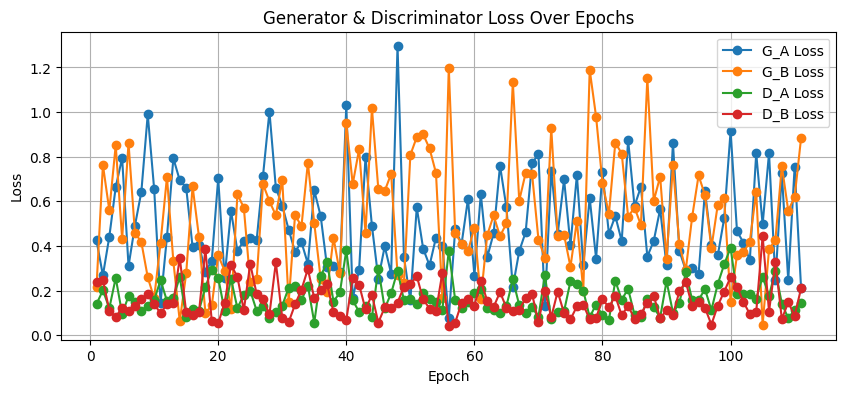

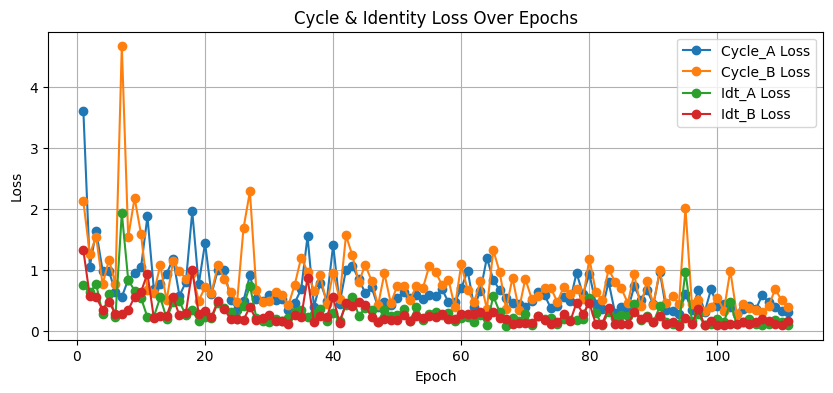

In [34]:
log_df = pd.read_csv('checkpoints/training_log.csv')

plt.figure(figsize=(10, 4))
plt.plot(log_df['epoch'], log_df['G_A'], '-o', label='G_A Loss')
plt.plot(log_df['epoch'], log_df['G_B'], '-o', label='G_B Loss')
plt.plot(log_df['epoch'], log_df['D_A'], '-o', label='D_A Loss')
plt.plot(log_df['epoch'], log_df['D_B'], '-o', label='D_B Loss')
plt.title("Generator & Discriminator Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(log_df['epoch'], log_df['cycle_A'], '-o', label='Cycle_A Loss')
plt.plot(log_df['epoch'], log_df['cycle_B'], '-o', label='Cycle_B Loss')
plt.plot(log_df['epoch'], log_df['idt_A'], '-o', label='Idt_A Loss')
plt.plot(log_df['epoch'], log_df['idt_B'], '-o', label='Idt_B Loss')
plt.title("Cycle & Identity Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
test_dir = r"C:\Users\User\PycharmProjects\DeepVisionFinalProject\cycleGAN_sunglassesFilter\dataset\testA"
output_dir = 'checkpoints/test_results'

In [38]:
def run_test_with_crop_and_compare (model, device, test_dir, output_dir, input_size=(256, 256)):
    os.makedirs(output_dir, exist_ok=True)  # ✅ יוצרת תיקייה אם לא קיימת
    print(test_dir)
    print(output_dir)

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    for img_name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_name)
        img_pil = Image.open(img_path).convert('RGB')
        img_resized = img_pil.resize(input_size)

        input_tensor = transform(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            fake_B = model.netG_A(input_tensor)

        fake_B_img = fake_B[0].cpu()
        fake_B_img = (fake_B_img + 1) / 2.0
        fake_B_img = fake_B_img.permute(1, 2, 0).numpy() * 255
        fake_B_img = fake_B_img.astype('uint8')

        # Convert images to OpenCV format
        original_bgr = cv2.cvtColor(np.array(img_resized), cv2.COLOR_RGB2BGR)
        fake_bgr = cv2.cvtColor(fake_B_img, cv2.COLOR_RGB2BGR)

        # שמירה של הפלט בלבד
        result_path = os.path.join(output_dir, f'fakeB_{img_name}')
        cv2.imwrite(result_path, fake_bgr)

        # שמירה של השוואה side-by-side
        combined = np.hstack((original_bgr, fake_bgr))
        comparison_path = os.path.join(output_dir, f'compare_{img_name}')
        cv2.imwrite(comparison_path, combined)

    print(f"✅ Test completed. Full image results saved to: {output_dir}")


In [40]:
run_test_with_crop_and_compare(model, device, test_dir, output_dir)


C:\Users\User\PycharmProjects\DeepVisionFinalProject\cycleGAN_sunglassesFilter\dataset\testA
checkpoints/test_results
✅ Test completed. Full image results saved to: checkpoints/test_results


In [41]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / max(gamma, 0.01)
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def run_cycleGAN_live_with_modes(model, device, input_size=(256, 256)):
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.7)

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Could not open webcam.")
        return

    print("Press 'q' to exit. Press 'm' to switch mode.")

    cv2.namedWindow("Sliders")
    cv2.createTrackbar("Contrast", "Sliders", 100, 300, lambda x: None)
    cv2.createTrackbar("Brightness", "Sliders", 100, 200, lambda x: None)
    cv2.createTrackbar("Gamma", "Sliders", 100, 300, lambda x: None)

    mode = 0  # 0 = G_A, 1 = G_B, 2 = G_A → G_B

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_flipped = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2RGB)
        results = face_detection.process(rgb_frame)

        mode_text = ['G_A (Add)', 'G_B (Remove)', 'Cycle A→B→A'][mode]

        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = frame_flipped.shape
                x = int(bboxC.xmin * w)
                y = int(bboxC.ymin * h)
                width = int(bboxC.width * w)
                height = int(bboxC.height * h)

                y = max(y - int(0.6 * height), 0)
                height = height + int(0.6 * height)
                face_crop = frame_flipped[y:y+height, x:x+width]

                if face_crop.size == 0 or face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
                    continue

                face_resized = cv2.resize(face_crop, input_size)
                face_pil = Image.fromarray(cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB))
                tensor = transform(face_pil).unsqueeze(0).to(device)

                with torch.no_grad():
                    if mode == 0:
                        fake = model.netG_A(tensor)
                        result = fake
                    elif mode == 1:
                        fake = model.netG_B(tensor)
                        result = fake
                    elif mode == 2:
                        fake = model.netG_A(tensor)
                        result = model.netG_B(fake)

                result_img = result[0].cpu()
                result_img = (result_img + 1) / 2.0
                result_img = result_img.permute(1, 2, 0).numpy() * 255
                result_img = result_img.astype('uint8')
                result_bgr = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)

                contrast = cv2.getTrackbarPos("Contrast", "Sliders") / 100.0
                brightness = cv2.getTrackbarPos("Brightness", "Sliders") - 100
                gamma = cv2.getTrackbarPos("Gamma", "Sliders") / 100.0

                adjusted = cv2.convertScaleAbs(result_bgr, alpha=contrast, beta=brightness)
                adjusted = adjust_gamma(adjusted, gamma)

                combined = np.hstack((face_resized, adjusted))
                cv2.imshow('Original | Transformed', combined)
                break

        cv2.putText(frame_flipped, f'Mode: {mode_text}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        cv2.imshow('Webcam', frame_flipped)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('m'):
            mode = (mode + 1) % 3
        elif key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [42]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / max(gamma, 0.01)
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def run_cycleGAN_live(model, device, input_size=(256, 256)):
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.7)

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Could not open webcam.")
        return

    print("Press 'q' to exit.")

    # === יצירת חלון עם סליידרים
    cv2.namedWindow("Sliders")
    cv2.createTrackbar("Contrast", "Sliders", 70, 300, lambda x: None)  # 1.0 = 100
    cv2.createTrackbar("Brightness", "Sliders", 70, 200, lambda x: None)  # 0 = 100
    cv2.createTrackbar("Gamma", "Sliders", 70, 300, lambda x: None)  # 1.0 = 100

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_flipped = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2RGB)

        results = face_detection.process(rgb_frame)

        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = frame_flipped.shape
                x = int(bboxC.xmin * w)
                y = int(bboxC.ymin * h)
                width = int(bboxC.width * w)
                height = int(bboxC.height * h)

                y = max(y - int(0.6 * height), 0)
                height = height + int(0.6 * height)

                face_crop = frame_flipped[y:y+height, x:x+width]
                if face_crop.size == 0 or face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
                    continue

                face_resized = cv2.resize(face_crop, input_size)
                face_pil = Image.fromarray(cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB))
                tensor = transform(face_pil).unsqueeze(0).to(device)

                with torch.no_grad():
                    fake_B = model.netG_A(tensor)

                fake_B_img = fake_B[0].cpu()
                fake_B_img = (fake_B_img + 1) / 2.0
                fake_B_img = fake_B_img.permute(1, 2, 0).numpy() * 255
                fake_B_img = fake_B_img.astype('uint8')
                fake_B_bgr = cv2.cvtColor(fake_B_img, cv2.COLOR_RGB2BGR)

                # === קבלת ערכים מהסליידרים
                contrast = cv2.getTrackbarPos("Contrast", "Sliders") / 100.0
                brightness = cv2.getTrackbarPos("Brightness", "Sliders") - 100
                gamma = cv2.getTrackbarPos("Gamma", "Sliders") / 100.0

                # === החלת ערכים
                adjusted = cv2.convertScaleAbs(fake_B_bgr, alpha=contrast, beta=brightness)
                adjusted = adjust_gamma(adjusted, gamma)

                combined = np.hstack((face_resized, adjusted))
                cv2.imshow('Original | Adjusted CycleGAN Output', combined)
                break

        cv2.imshow('Webcam', frame_flipped)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [43]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / max(gamma, 0.01)
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def run_cycleGAN_live_all_views(model, device, input_size=(256, 256)):
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.7)

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Could not open webcam.")
        return

    print("Press 'q' to exit.")

    cv2.namedWindow("Sliders")
    cv2.createTrackbar("Contrast", "Sliders", 100, 300, lambda x: None)
    cv2.createTrackbar("Brightness", "Sliders", 100, 200, lambda x: None)
    cv2.createTrackbar("Gamma", "Sliders", 100, 300, lambda x: None)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_flipped = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2RGB)
        results = face_detection.process(rgb_frame)

        if results.detections:
            for detection in results.detections:
                bbox = detection.location_data.relative_bounding_box
                h, w, _ = frame_flipped.shape
                x = int(bbox.xmin * w)
                y = int(bbox.ymin * h)
                width = int(bbox.width * w)
                height = int(bbox.height * h)

                y = max(y - int(0.6 * height), 0)
                height = height + int(0.6 * height)
                face_crop = frame_flipped[y:y+height, x:x+width]

                if face_crop.size == 0:
                    continue

                face_resized = cv2.resize(face_crop, input_size)
                face_pil = Image.fromarray(cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB))
                tensor = transform(face_pil).unsqueeze(0).to(device)

                with torch.no_grad():
                    fake_B = model.netG_A(tensor)
                    reconstructed_A = model.netG_B(fake_B)

                def tensor_to_img(t):
                    img = t[0].cpu()
                    img = (img + 1) / 2.0
                    img = img.permute(1, 2, 0).numpy() * 255
                    return img.astype('uint8')

                original_bgr = face_resized
                fake_bgr = cv2.cvtColor(tensor_to_img(fake_B), cv2.COLOR_RGB2BGR)
                rec_bgr = cv2.cvtColor(tensor_to_img(reconstructed_A), cv2.COLOR_RGB2BGR)

                contrast = cv2.getTrackbarPos("Contrast", "Sliders") / 100.0
                brightness = cv2.getTrackbarPos("Brightness", "Sliders") - 100
                gamma = cv2.getTrackbarPos("Gamma", "Sliders") / 100.0

                fake_bgr = adjust_gamma(cv2.convertScaleAbs(fake_bgr, alpha=contrast, beta=brightness), gamma)
                rec_bgr = adjust_gamma(cv2.convertScaleAbs(rec_bgr, alpha=contrast, beta=brightness), gamma)

                stacked = np.hstack((original_bgr, fake_bgr, rec_bgr))
                cv2.imshow("Original | G_A (Fake) | G_B(G_A) (Reconstruction)", stacked)
                break

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [48]:
run_cycleGAN_live_all_views(model, device)

Press 'q' to exit.


In [47]:
# run_cycleGAN_live_with_modes(model, device, input_size=(256, 256))

In [46]:
run_cycleGAN_live(model, device, input_size=(256, 256)) #### for presentation


Press 'q' to exit.


In [51]:
print(model.netD_A)

DataParallel(
  (module): NLayerDiscriminator(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    )
  )
)
